In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io as aio
import numpy as np
import numba
import pandas as pd
from scipy.spatial import cKDTree
from toolz.curried import pipe, curry, compose
import atom_stat as astat

In [3]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def draw(im):
    im1 = np.squeeze(im)
    plt.imshow(im1)
    plt.colorbar()
    plt.grid(False)
    plt.show()

## Estimate Distrubance in 3D

In our use of both two point statistics and rdf, we first extract atoms that constitute the substructure of interest (e.g. cascade or grain boundary) - then utilize either of these two metrics to aggregate the local environment around all the atoms constituting the substructure.

* Load coordinates of all atoms in 'coords_all'
* Load coordinates of disturbed atom in 'coords_sub' 
    * (They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file )
* The xyz file if available can be read with ase usin the following code snippet:

         atom = aio.read("file_name.xyz")
         coords = atom.get_positions()



In [8]:
import glob
len(glob.glob("structs/*.pkl"))

77

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [5]:
%%time
pka = 1000
run = 4
atoms = aio.read("xyz_05/cu_pka_{}_run_{}.xyz".format(pka, run))

idx = np.where(atoms.get_tags() != 1)[0]
print(len(idx))
coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

71
CPU times: user 106 ms, sys: 9.03 ms, total: 115 ms
Wall time: 127 ms


### Compute the vector counts and save them in a matrix called box

In [6]:
r_stat = 15 # radius of the statistics
len_pixel = 10 # voxel size

In [7]:
%%time
box = astat.get_voxelizedStats_tree(coords_all, coords_sub, r_stat, len_pixel)

/Users/apaarshanker/anaconda3/envs/atommks/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "atom_stat.py", line 237:
@numba.njit(parallel=True)
def box_count(box, indexes, N, shape):
^

  state.func_ir.loc))


CPU times: user 446 ms, sys: 193 ms, total: 639 ms
Wall time: 789 ms


### Visualize the vector counts

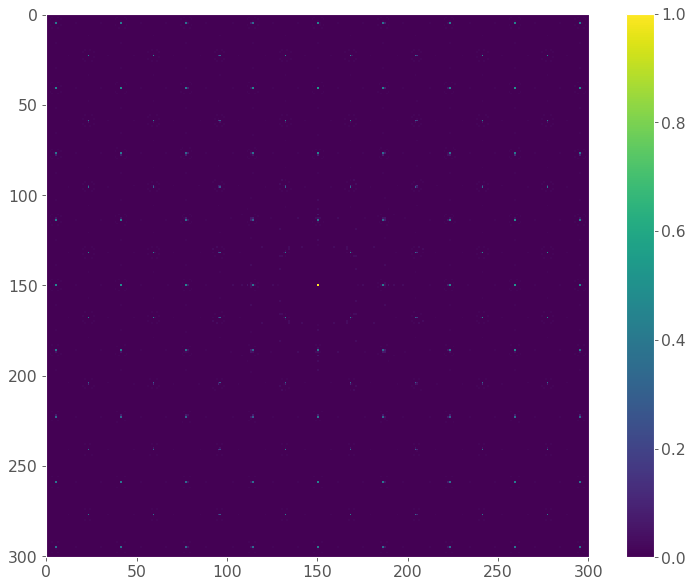

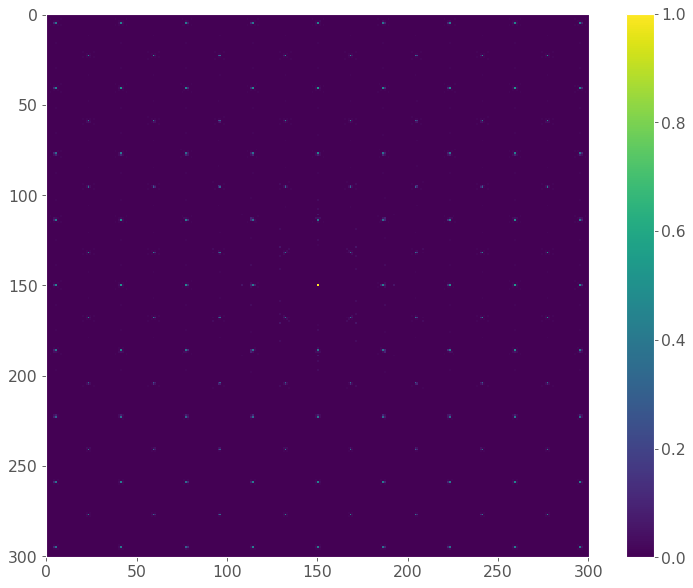

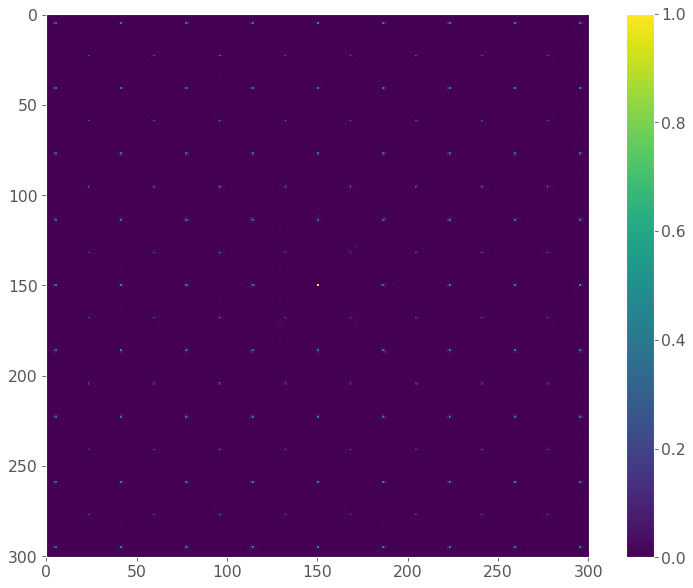

In [8]:
idx = int(r_stat * len_pixel)
draw(box[:,:, idx])
draw(box[:, idx, :])
draw(box[idx,:,:])

### Compute a smoothening filter for two point statistics

In [9]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

In [10]:
fs = pipe(r_s, 
          lambda r_s: astat.sphere(r_s * len_pixel),
          lambda s: astat.padder(s, new_shape), 
          lambda s: astat.imfilter(s, f_data=s) / np.count_nonzero(s))

### Visualize the smoothening filter

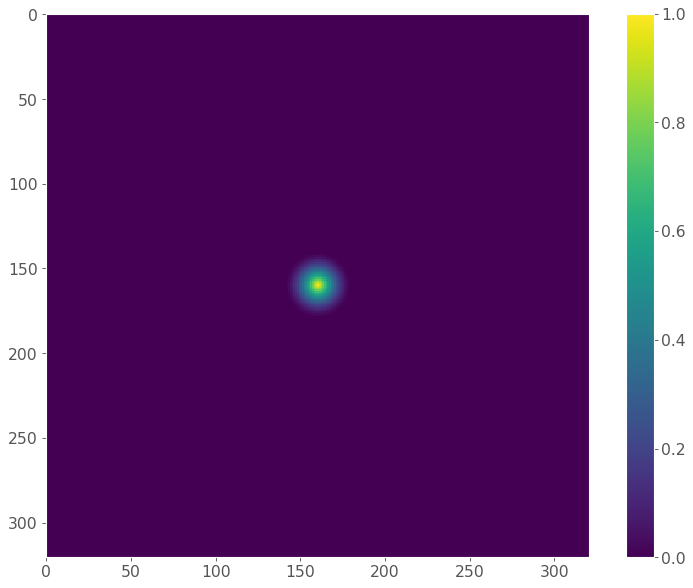

In [11]:
idx = int((r_stat + r_s) * len_pixel)
draw((fs[:,:, idx]))

## Apply the smoothening filter to the box

In [12]:
%%time
box1 = pipe(box, 
            lambda s: astat.padder(s, new_shape), 
            lambda s: astat.imfilter(s, f_data=fs))

CPU times: user 12.7 s, sys: 1.98 s, total: 14.7 s
Wall time: 14.8 s


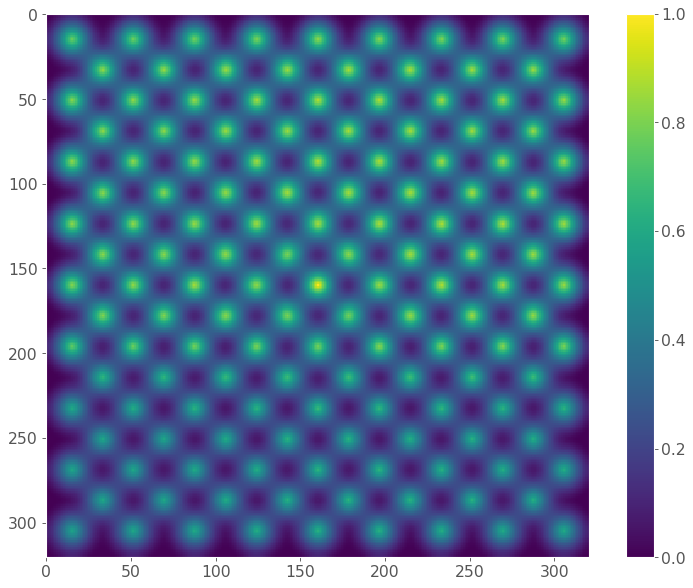

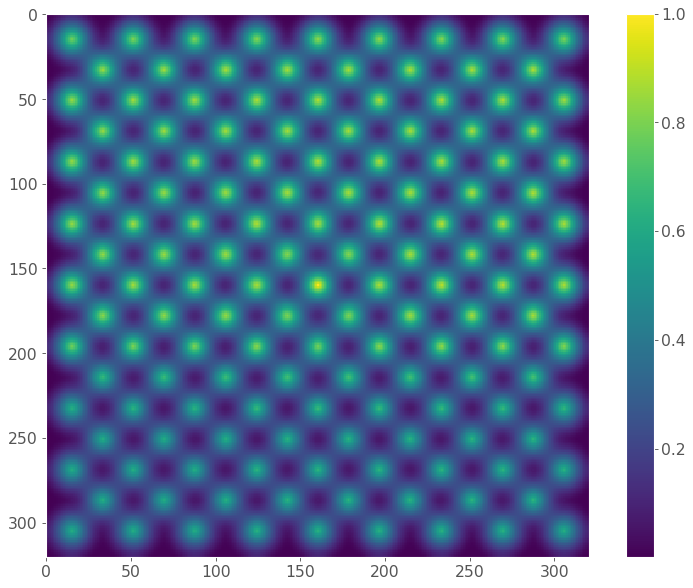

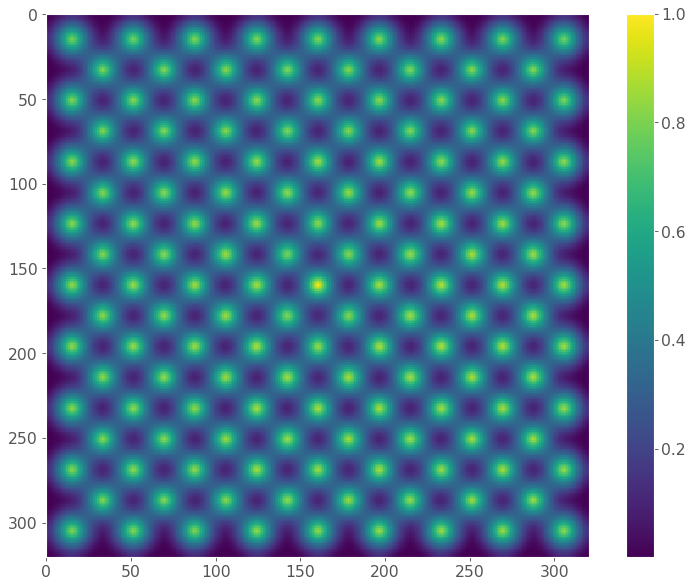

In [13]:
idx = int((r_stat + r_s) * len_pixel)
draw(box1[:,:, idx])
draw(box1[:, idx, :])
draw(box1[idx,:,:])